In [1]:
import sys
sys.path.insert(0, "../..")

In [27]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from logistic_regression import LogisticRegressionGD
from extrapolation import *
from experiments import Experiment

In [3]:
device = "cuda"

X = []
with open("../../../sido0_train.data") as f:
    for line in f:
        X.append([float(x) for x in line.split()])
X = np.array(X)
X = X[:11000]
X /= X.max()
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
X = torch.tensor(X, device=device)
with open("../../../sido0_train.targets") as f:
    y = [int(x) for x in f]
y = y[:11000]
y = torch.tensor(y, device=device)
X.shape, y.shape

(torch.Size([11000, 4933]), torch.Size([11000]))

In [5]:
np.random.seed(2020)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
model = LogisticRegressionGD(X_train, y_train, 1e-3, device="cuda")

In [7]:
model.fit(1e-5, max_iter=20500)

In [8]:
len(model.log)

16713

In [9]:
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.9777, device='cuda:0', dtype=torch.float64)

In [13]:
experiment = Experiment(model.log, model.obj, values=model.value_log, device="cuda")
k = 6

In [14]:
experiment.run_method("RRE+QR", RRE, k, method_kwargs={"qr": True})

In [15]:
experiment.run_method("MMPE", MMPE, k)

In [16]:
experiment.run_method("Regularized RRE", regularized_RRE, k, method_kwargs={"lambda_": 1e-10})

In [17]:
experiment.run_method("RNA+norm", RNA, k, method_kwargs={"lambda_range": (1e-15, 1e-2), "linesearch": False})

In [18]:
experiment.run_method("RNA+ls", RNA, k, method_kwargs={"lambda_range": (1e-15, 1e-2), "linesearch": True})

In [19]:
experiment.run_method("TEA", TEA_solve, 2*k, input_size=k)

In [20]:
experiment.run_method("Epsilon inv", vector_epsilon_v1, 2*k, method_kwargs={"k": k})

In [21]:
experiment.run_method("Epsilon mult", vector_epsilon_v2, 2*k, method_kwargs={"k": k})

In [32]:
experiment.run_method("Topological epsilon", topological_vector_epsilon, 2*k, method_kwargs={"k": k})

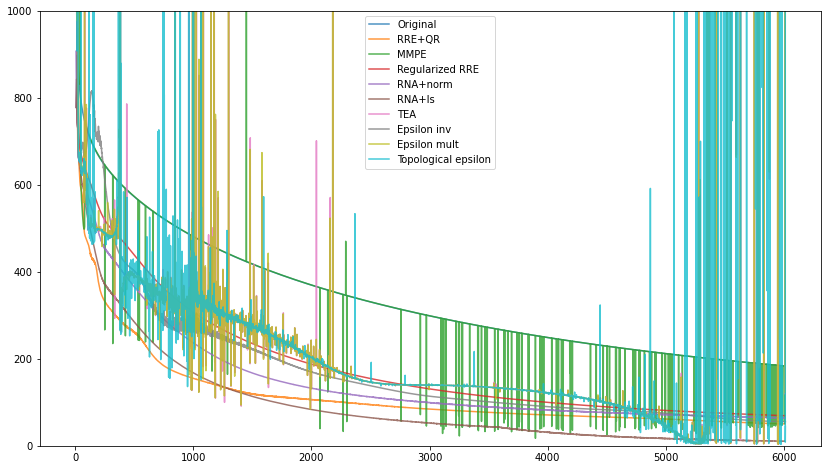

In [41]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=6000)
plt.ylim(0, 1000)
plt.legend()

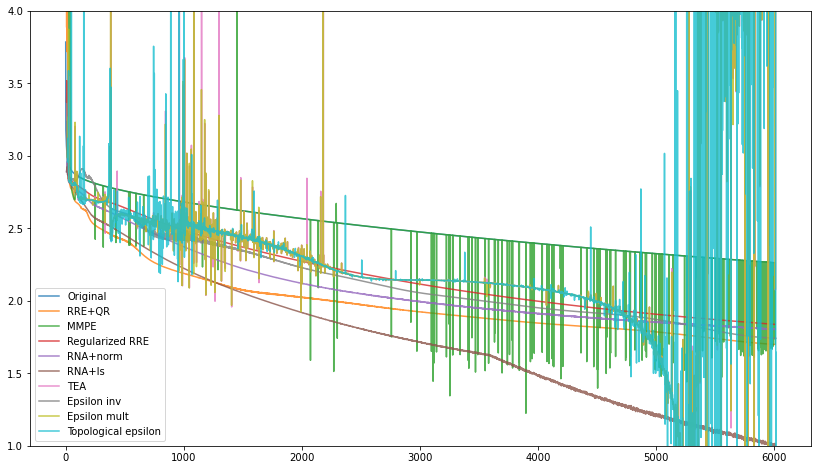

In [42]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=6000)
plt.ylim(1, 4)
plt.legend()

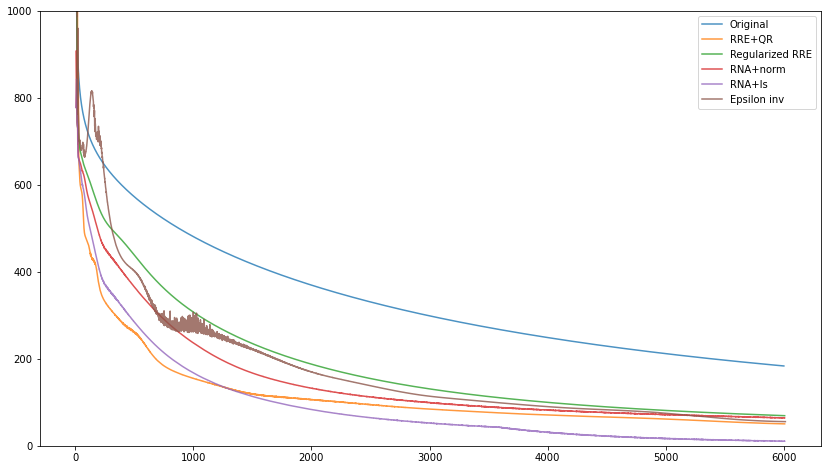

In [44]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=6000, methods=["RRE+QR", "Regularized RRE", "RNA+norm", "RNA+ls", "Epsilon inv"])
plt.ylim(0, 1000)
plt.legend()

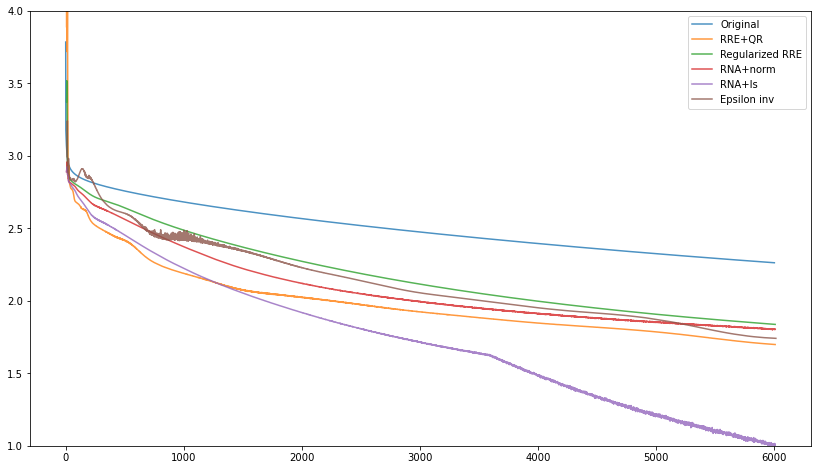

In [46]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=6000, methods=["RRE+QR", "Regularized RRE", "RNA+norm", "RNA+ls", "Epsilon inv"])
plt.ylim(1, 4)
plt.legend()

In [35]:
df = experiment.value_df()
df.to_csv("results/sido0-new-methods.csv")